In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [66]:
X, labels = make_moons(n_samples=2000, noise=0.1, random_state=42)
X = X

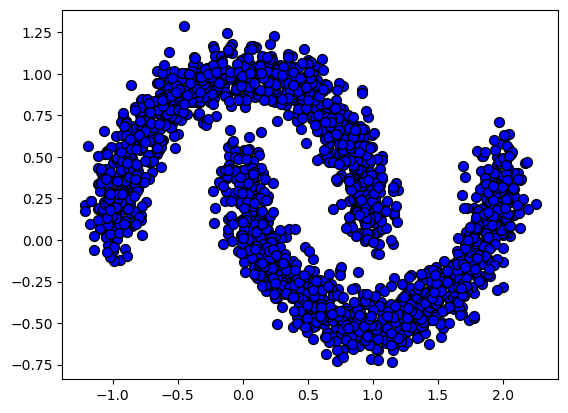

In [67]:
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50)
plt.show()

In [68]:
data = torch.tensor(X, dtype=torch.float32).to(device)

In [69]:
class MLPStudent(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)  # +1 for time conditioning
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, t):
        t = t.view(-1, 1)  # Ensure time is a column vector
        xt = torch.cat([x, t], dim=1)  # Concatenate x and t
        h = F.silu(self.fc1(xt))
        h = F.silu(self.fc2(h))
        h = F.silu(self.fc3(h))
        h = F.silu(self.fc4(h))
        return (t==0).float()*x+(1-(t==0).float())*(self.fc5(h))  # Predicts an update for x

In [ ]:
class ConsistencyModel:
    def __init__(self, student_model, timesteps=80, learning_rate=4e-4, mu=0.95, beta_start=0.001, beta_end=0.2):
        self.student_model = student_model  # Consistency model
        self.timesteps =  timesteps
        self.learning_rate = learning_rate
        self.mu = mu  # EMA parameter
        self.optimizer = optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
        self.theta_minus_model = self.create_ema_model()
    
    def create_ema_model(self):
        """ Create a copy of the student model for EMA tracking """
        ema_model = type(self.student_model)()  # Instantiate the same model type
        ema_model.load_state_dict(self.student_model.state_dict())  # Copy parameters
        for param in ema_model.parameters():
            param.requires_grad = False  # Freeze EMA model
        return ema_model.to(device)
    
    def update_ema(self):
        """ Exponential Moving Average (EMA) update for θ⁻ """
        with torch.no_grad():
            for param, param_ema in zip(self.student_model.parameters(), self.theta_minus_model.parameters()):
                param_ema.data = self.mu * param_ema.data + (1 - self.mu) * param.data

    def train(self, dataset, epochs=1000, batch_size=64):
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(epochs):
            epoch_loss = 0
            for x in dataloader:
                self.optimizer.zero_grad()
                
                # Sample t_n and t_{n+1}
                n = torch.randint(0, self.timesteps-2, (x.size(0),), device=x.device)
                t_n = n
                
                t_np1 = n+1
                
                # Sample x_{t_{n+1}}
                #noise = torch.randn_like(x, device=x.device)
                noise = torch.randn_like(x, dtype=torch.float32, device=x.device)
                x_tnp1 = torch.sqrt(self.alphas_cumprod[t_np1]).view(-1, 1) * x + torch.sqrt(1.0 - self.alphas_cumprod[t_np1]).view(-1, 1) * noise
                
                x_tn = torch.sqrt(self.alphas_cumprod[t_n]).view(-1, 1) * x + torch.sqrt(1.0 - self.alphas_cumprod[t_n]).view(-1, 1) * noise
                
                # Compute student output
                student_output = self.student_model(x_tnp1, t_np1)
                
                with torch.no_grad():  # Stop gradient flow
                    theta_minus_output = self.theta_minus_model(x_tn, t_n)
                
                # Compute loss
                loss = self.loss_fn(student_output, theta_minus_output)
                loss.backward()
                self.optimizer.step()
                
                # EMA update
                self.update_ema()
                
                epoch_loss += loss.item()
            
            if epoch%100==0:
                print(f"Epoch {epoch}, Loss: {epoch_loss / len(dataloader)}")
        
        return self.student_model

In [71]:
student_model = MLPStudent().to(device)

consistency_model = ConsistencyModel(student_model)

student_model = consistency_model.train(data, epochs=5000, batch_size=128)

tensor([9.9900e-01, 9.9548e-01, 9.8947e-01, 9.8101e-01, 9.7014e-01, 9.5695e-01,
        9.4153e-01, 9.2399e-01, 9.0444e-01, 8.8304e-01, 8.5991e-01, 8.3522e-01,
        8.0914e-01, 7.8183e-01, 7.5348e-01, 7.2426e-01, 6.9434e-01, 6.6391e-01,
        6.3315e-01, 6.0221e-01, 5.7127e-01, 5.4048e-01, 5.0999e-01, 4.7993e-01,
        4.5043e-01, 4.2162e-01, 3.9358e-01, 3.6642e-01, 3.4021e-01, 3.1502e-01,
        2.9090e-01, 2.6789e-01, 2.4603e-01, 2.2533e-01, 2.0581e-01, 1.8746e-01,
        1.7027e-01, 1.5423e-01, 1.3931e-01, 1.2549e-01, 1.1272e-01, 1.0096e-01,
        9.0181e-02, 8.0323e-02, 7.1340e-02, 6.3182e-02, 5.5797e-02, 4.9136e-02,
        4.3145e-02, 3.7777e-02, 3.2981e-02, 2.8711e-02, 2.4922e-02, 2.1569e-02,
        1.8614e-02, 1.6016e-02, 1.3741e-02, 1.1754e-02, 1.0025e-02, 8.5253e-03,
        7.2283e-03, 6.1104e-03, 5.1499e-03, 4.3275e-03, 3.6255e-03, 3.0283e-03,
        2.5218e-03, 2.0937e-03, 1.7329e-03, 1.4300e-03, 1.1764e-03, 9.6485e-04,
        7.8889e-04, 6.4304e-04, 5.2253e-

KeyboardInterrupt: 

In [ ]:
def sample_consistency_model(model, num_samples=10000):
    x = torch.randn((num_samples, 2), device=device)  # Initialize with noise
    t = torch.ones(num_samples, device=device)*(consistency_model.timesteps-1)  # Use t=0 for final samples
    with torch.no_grad():
        x = model(x, t)
    return x

samples = sample_consistency_model(student_model, num_samples=2000).cpu().detach().numpy()

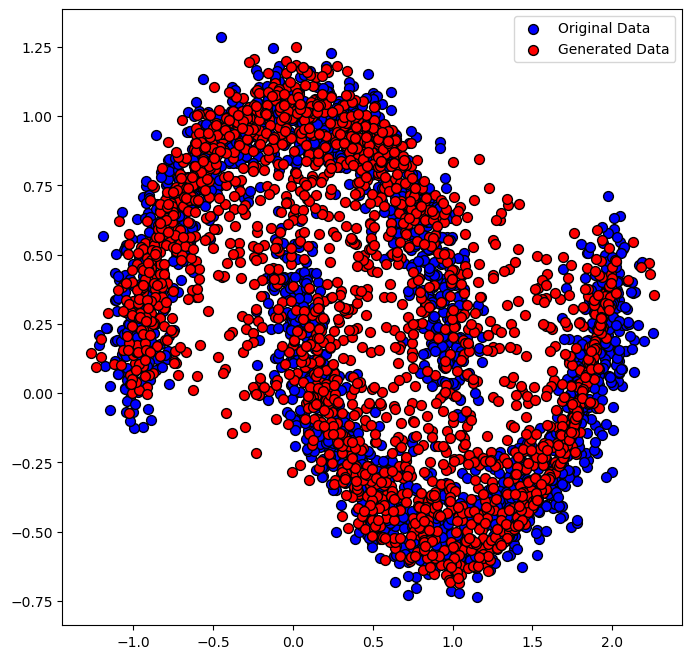

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', edgecolor='k', s=50, label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], c='red', marker='o', edgecolor='k', s=50, label='Generated Data')
plt.legend()
plt.show()